# Part I (Bootstrapping Swap Curves)
We start by importing the following needed for our computation:
1. Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import brentq, least_squares

import warnings
warnings.filterwarnings("ignore")

2. Datasets

We will be using two datasets, each containing the columns "Tenor", "Product" and "Rate".

**(a) IRS**
- Convention: 30/360
- Fixed Leg Freq: Semi-annual
- Floating Leg Freq: Semi-annual

In [2]:
def convert_tenor_to_years(tenor):
    return int(tenor[:-1]) if tenor[-1] == 'y' else int(tenor[:-1]) / 12

irs_data = pd.read_excel("IR Data.xlsx", sheet_name = "IRS").iloc[:,:3]
irs_data["Tenor"] = irs_data["Tenor"].apply(convert_tenor_to_years)
irs_data.T

,0,1,2,3,4,5,6,7,8,9,10
Tenor,0.5,1.0,2.0,3.0,4.0,5.0,7.0,10.0,15.0,20.0,30.0
Product,LIBOR,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS,IRS
Rate,0.025,0.028,0.03,0.0315,0.0325,0.033,0.035,0.037,0.04,0.045,0.05


**(b) OIS**
- Day Count Convention: 30/360
- O/N Leg Frequency: Daily
- Fixed Leg Frequency: Annual

In [3]:
ois_data = pd.read_excel("IR Data.xlsx", sheet_name = "OIS").iloc[:,:3]
ois_data["Tenor"] = ois_data["Tenor"].apply(convert_tenor_to_years)
ois_data.T

,0,1,2,3,4,5,6,7,8,9,10
Tenor,0.5,1.0,2.0,3.0,4.0,5.0,7.0,10.0,15.0,20.0,30.0
Product,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS,OIS
Rate,0.0025,0.003,0.00325,0.00335,0.0035,0.0036,0.004,0.0045,0.005,0.00525,0.0055


## Questions
For each of the questions below, use linear interpolation on discount factors when necessary.
1. In the `IR Data.xlsm` spreadsheet, OIS data is provided. Bootstrap the OIS discount factor $D_o(0,T)$ and plot the discount curve for $T\in[0,30]$.
### Curve fitting
Let $f_0$ denote the daily compounded overnight rate for $[0, 6m]$. Using the $6m$ OIS, we have:
\begin{align*}
PV^{6m\,\text{OIS}}_{fix}&=PV^{6m\,\text{OIS}}_{flt}\\
D_o(0,6m)\times\frac{6m}{1y}\times0.25\%&=D_o(0,6m)\times\left[\left(1+\frac{f_0}{360}\right)^{360\times\frac{6m}{1y}}-1\right]
\end{align*}
We can now solve for $f_0$ as follows:
$$
\left(1+\frac{f_0}{360}\right)^{180}-1=0.5\times0.25\%\Rightarrow f_0=360\times\left[(1+0.5\times0.25\%)^{\frac{1}{180}}-1\right]
$$
Having obtained this, we can then let $f_1$ denote the daily compounded overnight rate for $[6m, 1y]$. Using the $1y$ OIS, we have:
\begin{align*}
PV^{1y\,\text{OIS}}_{fix}&=PV^{1y\,\text{OIS}}_{flt}\\
D_o(0,1y)\times0.3\%&=D_o(0,1y)\times\left[\left(1+\frac{f_0}{360}\right)^{180}\left(1+\frac{f_1}{360}\right)^{180}-1\right]
\end{align*}
We can now solve for $f_1$ as follows:
$$
\left(1+\frac{f_0}{360}\right)^{180}\left(1+\frac{f_1}{360}\right)^{180}-1=0.3\%\Rightarrow f_1=360\times\left[\frac{(1+0.3\%)^{\frac{1}{180}}}{1+\frac{f_0}{360}}-1\right]
$$
Next, we move on to the $2y$ OIS. Let $f_2$ denote the daily compounded overnight rate for $[1y, 2y]$, we have:
\begin{align*}
PV^{2y\,\text{OIS}}_{fix}&=PV^{2y\,\text{OIS}}_{flt}\\
[D_o(0,1y)+D_o(0,2y)]\times0.325\%&=D_o(0,1y)\times\left[\left(1+\frac{f_0}{360}\right)^{180}\left(1+\frac{f_1}{360}\right)^{180}-1\right]+D_o(0,2y)\times\left[\left(1+\frac{f_2}{360}\right)^{360}-1\right]\\
D_o(0,1y)\times0.025\%+D_o(0,2y)\times0.325\%&=D_o(0,2y)\times\left[\left(1+\frac{f_2}{360}\right)^{360}-1\right]
\end{align*}
Using the formula $D_o(t,T)=\frac{D_o(t_0,T)}{D_o(t_0,t)}$ with $t_0<t<T$, we can now solve for $f_2$ as follows:
\begin{align*}
\left(1+\frac{f_2}{360}\right)^{360}-1&=0.325\%+\frac{0.025\%}{D_o(1y,2y)}\Rightarrow f_2=360\times\left[\left(1+0.325\%+\frac{0.025\%}{D_o(1y,2y)}\right)^{\frac{1}{360}}-1\right]\approx360\times\left[(1+0.325)^{\frac{1}{360}}-1\right]
\end{align*}
Similarly, we can obtain approximate values of $f_3$, $f_4$, $f_5$, $f_7$, $f_{10}$, $f_{15}$, $f_{20}$ and $f_{30}$:
\begin{align*}
f_3&\approx360\times\left[(1+0.335\%)^{\frac{1}{360}}-1\right],\,\,f_4\approx360\times\left[(1+0.35\%)^{\frac{1}{360}}-1\right],\,\,f_5\approx360\times\left[(1+0.36\%)^{\frac{1}{360}}-1\right],\,\,f_7\approx360\times\left[(1+0.4\%)^{\frac{1}{360}}-1\right],\\
f_{10}&\approx360\times\left[(1+0.45\%)^{\frac{1}{360}}-1\right],\,\,f_{15}\approx360\times\left[(1+0.5\%)^{\frac{1}{360}}-1\right],\,\,f_{20}\approx360\times\left[(1+0.525\%)^{\frac{1}{360}}-1\right],\,\,f_{30}\approx360\times\left[(1+0.55\%)^{\frac{1}{360}}-1\right]
\end{align*}
We can then compute the OIS discount factors $D_o(0,T)$ using the formula:
$$
D_o(0,T_i)=\frac{1}{1+f_i\times T_i}
$$
where $T_0=0.5$ and $T_i=i$ (for $i\in\{1,2,3,4,5,7,10,20,30\}$) are measured in years.

In [4]:
# Introduce and format new columns
ois_data['OIS overnight rate'] = np.nan
ois_data['OIS discount factor'] = np.nan

def calculate_discount_factors(row, df):
    """
    Calculate the overnight rate and discount factor dynamically based on the Tenor and Rate,
    ensuring proper handling of tenor intervals.

    Parameters:
    row: Row of the dataframe to compute the values for.
    df: The full dataframe for reference.

    Returns:
    Tuple of overnight rate and discount factor.
    """
    tenor = row["Tenor"]
    rate = row["Rate"]

    if tenor <= 0 or pd.isna(rate):
        return np.nan, np.nan  # Handle invalid or missing data

    # Calculate the annualized overnight rate
    overnight_rate = 360 * ((1 + rate) ** (1 / 360) - 1)

    # Find the previous tenor's discount factor
    previous_tenor = df[df["Tenor"] < tenor]["Tenor"].max()
    if pd.isna(previous_tenor):
        previous_tenor = 0  # Start at 0 tenor

    # Calculate the discount factor using the formula
    discount_factor = 1 / (1 + overnight_rate * tenor)

    return overnight_rate, discount_factor

# Apply the calculation and expand the results into two columns
ois_data[["OIS overnight rate", "OIS discount factor"]] = ois_data.apply(
    lambda row: pd.Series(calculate_discount_factors(row, ois_data)), axis=1
)
ois_data.rename(columns={'Product': 'OIS product', 'Rate': 'OIS rate'}, inplace=True)
ois_data

,Tenor,OIS product,OIS rate,OIS overnight rate,OIS discount factor
0,0.5,OIS,0.00250,0.002497,0.998753
1,1.0,OIS,0.00300,0.002996,0.997013
2,2.0,OIS,0.00325,0.003245,0.993552
3,3.0,OIS,0.00335,0.003344,0.990066
4,4.0,OIS,0.00350,0.003494,0.986217
5,5.0,OIS,0.00360,0.003594,0.982349
6,7.0,OIS,0.00400,0.003992,0.972815
7,10.0,OIS,0.00450,0.004490,0.957030
8,15.0,OIS,0.00500,0.004988,0.930394
9,20.0,OIS,0.00525,0.005236,0.905202


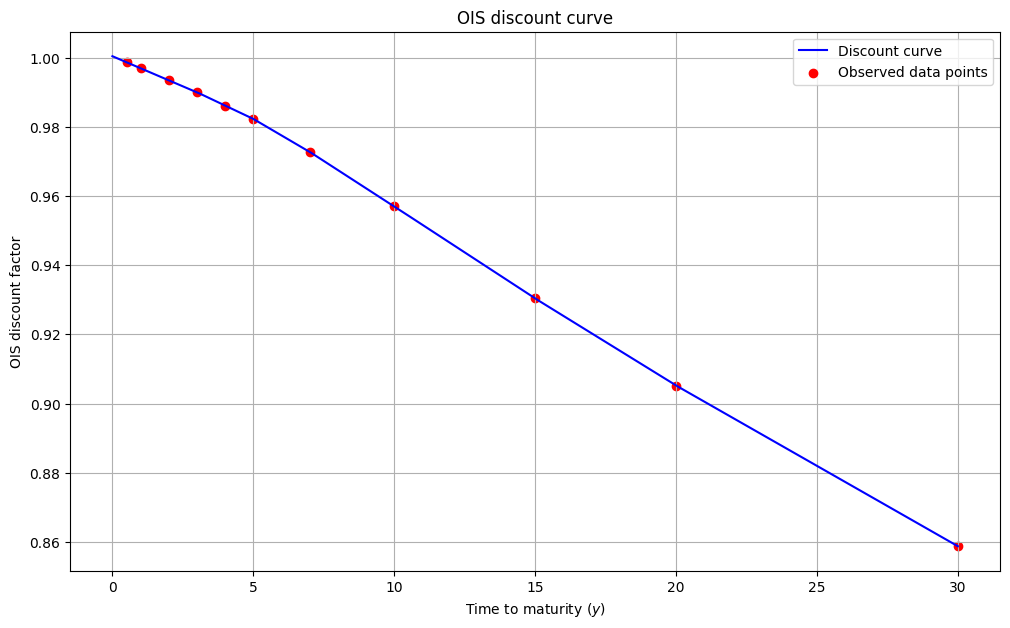

In [5]:
terms = np.linspace(0, 30, 1200)

# Linear interpolation based on tenors and discount factors
cs = interp1d(ois_data['Tenor'].values, ois_data['OIS discount factor'].values, kind='linear', fill_value='extrapolate')

# Evaluate the spline function over the range of terms to get interpolated discount factors
interpolated_discount_factors = cs(terms)

plt.figure(figsize=(12, 7))
plt.plot(terms, interpolated_discount_factors, label='Discount curve', color='blue')
plt.scatter(ois_data['Tenor'], ois_data['OIS discount factor'], color='red', label='Observed data points')
plt.title('OIS discount curve')
plt.xlabel('Time to maturity ($y$)')
plt.ylabel('OIS discount factor')
plt.legend()
plt.grid(True)
plt.show()

2. Using the IRS data provided, bootstrap the LIBOR discount factor $D(0,T)$, and plot it for $T\in[0,30]$, assuming that the swap market is collateralized in cash and overnight interest is paid on collateral posted.

In [6]:
irs_data =\
(
    pd
    .DataFrame(np.arange(0.5, 30.5, 0.5), columns=['Tenor'])
    .merge(irs_data, on='Tenor', how='outer')
    .sort_values('Tenor')
    .reset_index(drop=True)
)
ois_data =\
(
    pd
    .DataFrame(np.arange(0.5, 30.5, 0.5), columns=['Tenor'])
    .merge(ois_data, on='Tenor', how='outer')
    .sort_values('Tenor')
    .reset_index(drop=True)
)

oisirs_data = pd.merge(ois_data, irs_data, on = 'Tenor', how = 'left')

# Introduce new columns
oisirs_data['LIBOR forward rate'] = np.nan
oisirs_data['LIBOR discount factor'] = np.nan
oisirs_data.rename(columns={'Product': 'IRS product', 'Rate': 'IRS rate'}, inplace=True)

Given the forward LIBOR rate $L(0, 6m)$, we use the formula:
$$
D(0, 6m) = \frac{1}{1+0.5\times L(0,6m)}
$$
to obtain the first discount factor $D(0, 6m)$.

In [7]:
# Obtain the first forward rate using the 6-month LIBOR IRS rate
oisirs_data.at[0, 'LIBOR forward rate'] = oisirs_data.at[0, 'IRS rate']

# Calculate the first discount factor using the computed forward rate
oisirs_data.at[0, 'LIBOR discount factor'] = 1 / (1 + oisirs_data.at[0, 'IRS rate'] * (oisirs_data.at[0, 'Tenor']))
oisirs_data['OIS discount factor'].interpolate(method = 'linear', inplace = True)

To obtain the second forward LIBOR rate $L(6m, 1y)$, we use the formula:
$$
PV_{fix}^{1y\,\text{IRS}} = PV_{flt}^{1y\,\text{IRS}}
$$
$$
0.5 \times 0.025 \times [D_o(0, 6m) + D_o(0, 1y)]= 0.5 \times [(D_o(0, 6m) \times L(0, 6m)) + (D_o(0, 1y) \times L(6m, 1y))]
$$
We can then solve for $D(0, 1y)$ using $L(6m, 1y)$.

In [8]:
# Calculate the second forward rate using the 1-year OIS discount rate and the first forward rate
oisirs_data.at[1, 'LIBOR forward rate'] =\
(
    (oisirs_data.at[1, 'IRS rate'] * (oisirs_data.at[0, 'OIS discount factor'] + oisirs_data.at[1, 'OIS discount factor'])
     - (oisirs_data.at[0, 'LIBOR forward rate'] * oisirs_data.at[0, 'OIS discount factor'])) / oisirs_data.at[1, 'OIS discount factor']
)

# Calculate the second discount factor using the first and second forward rates
oisirs_data.at[1, 'LIBOR discount factor'] =\
(
    1 / (1 + oisirs_data.at[0, 'Tenor'] * oisirs_data.at[0, 'LIBOR forward rate'])
    * (1 / (1 + oisirs_data.at[0, 'Tenor'] * oisirs_data.at[1, 'LIBOR forward rate']))
)
oisirs_data['OIS discount factor'].interpolate(method = 'linear', inplace = True)

To obtain subsequent forward LIBOR and discount rates, we use the generalized relation:
$$
PV_{fix}^{T\,\text{IRS}} = PV_{flt}^{T\,\text{IRS}}\Rightarrow K \sum_{i=1}^{n} \Delta_{i-1} D(0, T_i) = \sum_{i=1}^{n} D(0, T_i) \Delta_{i-1} L(T_{i-1}, T_i)
$$
which equates the fixed and floating legs at each tenor $T$.

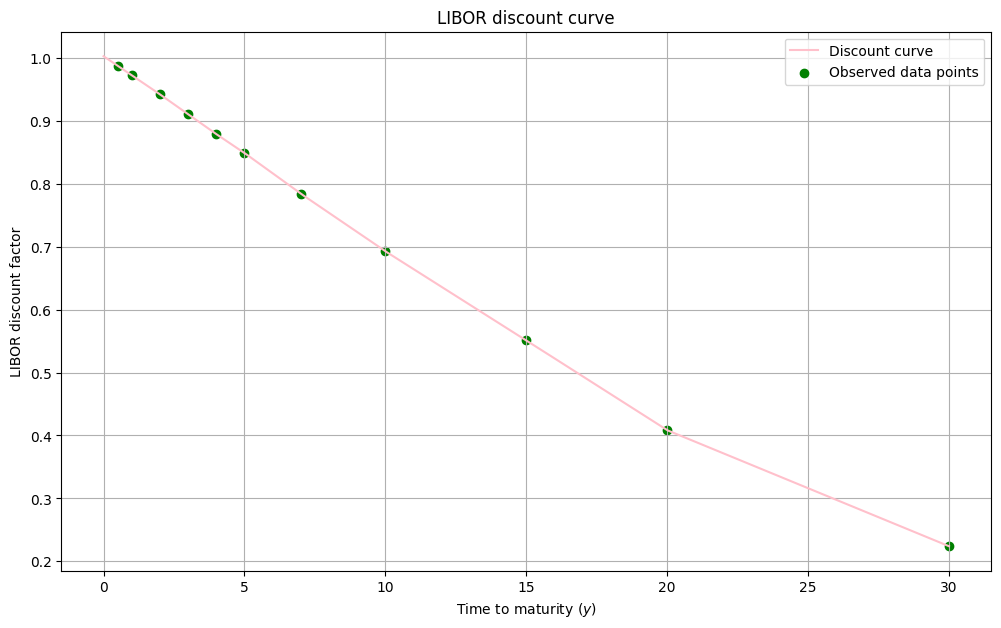

In [11]:
def libor_df(x):
    df_diff = oisirs_data['LIBOR discount factor'][i-2] - x
    df_p = [oisirs_data['LIBOR discount factor'][i-2]]
    libor_payment = []

    for n in range(0, h - i + 2):
        df_c = x + ((h - i - n + 1)/(h - i + 2)) * df_diff
        libor = 0.5 * (2 * (df_p[-1] - df_c) / df_c) * oisirs_data['OIS discount factor'][i - 1 + n]
        df_p.append(df_c)
        libor_payment.append(libor)
    flt_x = sum(libor_payment)

    return flt_x + flt - fix

i = 3

while i <= 60:
    h = i

    # Ensure h is within the dataframe index range
    while np.isnan(oisirs_data['IRS rate'][h]): h += 2

    fix = 0.5 * oisirs_data['IRS rate'][h] * oisirs_data['OIS discount factor'][0 : h + 1].sum()
    flt = 0
    k = 0

    while k <= i - 2:
        flt_i = 0.5 * oisirs_data['OIS discount factor'][k] * oisirs_data['LIBOR forward rate'][k]
        flt += flt_i
        k += 1
        
    f = lambda x: libor_df(x)
    df_libor = brentq(f, 0, 1)

    for n in range(0, h - i + 2):
        oisirs_data['LIBOR discount factor'][i - 1 +n] =\
        (
            df_libor + ((h - i - n + 1)/(h - i + 2)) * (oisirs_data['LIBOR discount factor'][i-2] - df_libor)
        )
        oisirs_data['LIBOR forward rate'][i-1+n] =\
        (
            (oisirs_data['LIBOR discount factor'][i - 2 + n] - oisirs_data['LIBOR discount factor'][i - 1 + n])
            / (0.5 * oisirs_data['LIBOR discount factor'][i - 1 + n])
        )
    
    i = h + 2

oisirs_data_final = oisirs_data.dropna()
oisirs_data_final.to_csv("discount_factors.csv", index=False)

terms = np.linspace(0, 30, 1200)

# Linear interpolation based on the tenor and discount factors
cs = interp1d(oisirs_data_final['Tenor'].values, oisirs_data_final['LIBOR discount factor'].values,
              kind='linear', fill_value='extrapolate')

# Evaluate the spline function over the range of terms to get interpolated discount factors
interpolated_discount_factors = cs(terms)

plt.figure(figsize=(12, 7))
plt.plot(terms, interpolated_discount_factors, label='Discount curve', color='pink')
plt.scatter(oisirs_data_final['Tenor'], oisirs_data_final['LIBOR discount factor'], color='green', label='Observed data points')
plt.title('LIBOR discount curve')
plt.xlabel('Time to maturity ($y$)')
plt.ylabel('LIBOR discount factor')
plt.legend()
plt.grid(True)
plt.show()

3. Calculate the following forward swap rates:
    - $1y \times 1y, 1y \times 2y, 1y \times 3y, 1y \times 5y, 1y \times 10y$
    - $5y \times 1y, 5y \times 2y, 5y \times 3y, 5y \times 5y, 5y \times 10y$
    - $10y \times 1y, 10y \times 2y, 10y \times 3y, 10y \times 5y, 10y \times 10y$
  
To do this, we use the formula: 
$$ S(T_i,T_{i+m}) = \frac{\sum\limits_{n=i+1}^{i+m} {D_o(0,T_n)\times0.5\times L(T_{n-0.5},T_n)}}{0.5\times\sum\limits_{n=i+1}^{i+m} D_o(0,T_n)}$$

In [10]:
expiry = ['1Y', '5Y', '10Y']
tenors = ['1Y', "2Y", '3Y', '5Y', '10Y']

par_swap_rate = []

for expiries in expiry:
    for tenor in tenors:

        i = int(expiries.strip()[:-1]) 
        j = int(tenor.strip()[:-1])
        
        fix = 0.5 * sum(oisirs_data['OIS discount factor'][2 * i : 2 * (i + j)])
        
        terms = []
        for x in range(2 * i, 2 * (i + j)):
            flt =\
            (
                oisirs_data['OIS discount factor'][x]
                * (oisirs_data['LIBOR discount factor'][x-1] - oisirs_data['LIBOR discount factor'][x])
                / oisirs_data['LIBOR discount factor'][x]
            )
            terms.append(flt)
        flt_payment = sum(terms)
        
        par_swap_rate.append(flt_payment / fix)

par_swap_rate_table = np.array(par_swap_rate).reshape(3, 5)
par_swap_rate = pd.DataFrame(par_swap_rate_table, columns = tenors, index = expiry)
par_swap_rate.to_csv("par_swap_rate.csv")
par_swap_rate

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038427
5Y,0.039273,0.040074,0.040070,0.041091,0.043629
10Y,0.042179,0.043105,0.044086,0.046238,0.053433
